In [70]:
import numpy as np
#import pyaudio as pa
import os, time
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

import nemo
import nemo.collections.asr as nemo_asr

SAMPLE_RATE = 16000

vad_model = nemo_asr.models.EncDecClassificationModel.from_pretrained('MatchboxNet-VAD-3x2')

from omegaconf import OmegaConf
import copy

cfg = copy.deepcopy(vad_model._cfg)
print(OmegaConf.to_yaml(cfg))

[NeMo I 2021-02-12 15:24:42 cloud:56] Found existing object /home/lucas/.cache/torch/NeMo/NeMo_1.0.0b2/MatchboxNet_VAD_3x2/1375f3813383105a24acc75428ec51c4/MatchboxNet_VAD_3x2.nemo.
[NeMo I 2021-02-12 15:24:42 cloud:62] Re-using file from: /home/lucas/.cache/torch/NeMo/NeMo_1.0.0b2/MatchboxNet_VAD_3x2/1375f3813383105a24acc75428ec51c4/MatchboxNet_VAD_3x2.nemo
[NeMo I 2021-02-12 15:24:42 common:399] Instantiating model from pre-trained checkpoint
[NeMo I 2021-02-12 15:24:42 modelPT:257] Model EncDecClassificationModel was successfully restored from /home/lucas/.cache/torch/NeMo/NeMo_1.0.0b2/MatchboxNet_VAD_3x2/1375f3813383105a24acc75428ec51c4/MatchboxNet_VAD_3x2.nemo.
sample_rate: 16000
timesteps: 64
repeat: 2
dropout: 0.0
kernel_size_factor: 1.0
labels:
- background
- speech
train_ds:
  manifest_filepath: /home/fjia/code/manifest64/balanced_background_training_manifest.json,/home/fjia/code/manifest64/balanced_speech_training_manifest.json
  sample_rate: 16000
  labels:
  - background
  

[NeMo W 2021-02-12 15:24:42 modelPT:110] Please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /home/fjia/code/manifest64/balanced_background_training_manifest.json,/home/fjia/code/manifest64/balanced_speech_training_manifest.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 128
    num_workers: 20
    shuffle: true
    augmentor:
      shift:
        prob: 0.8
        min_shift_ms: -5.0
        max_shift_ms: 5.0
      white_noise:
        prob: 0.8
        min_level: -90
        max_level: -46
    
[NeMo W 2021-02-12 15:24:42 modelPT:117] Please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /home/fjia/code/manifest64/balanced_background_validation_manifest.json,/home/

In [71]:
vad_model.preprocessor = vad_model.from_config_dict(cfg.preprocessor)
vad_model.eval();
vad_model = vad_model.to(vad_model.device)

In [72]:
from nemo.core.classes import IterableDataset
from nemo.core.neural_types import NeuralType, AudioSignal, LengthsType
import torch
from torch.utils.data import DataLoader

# simple data layer to pass audio signal
class AudioDataLayer(IterableDataset):
    @property
    def output_types(self):
        return {
            'audio_signal': NeuralType(('B', 'T'), AudioSignal(freq=self._sample_rate)),
            'a_sig_length': NeuralType(tuple('B'), LengthsType()),
        }

    def __init__(self, sample_rate):
        super().__init__()
        self._sample_rate = sample_rate
        self.output = True
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if not self.output:
            raise StopIteration
        self.output = False
        return torch.as_tensor(self.signal, dtype=torch.float32), \
               torch.as_tensor(self.signal_shape, dtype=torch.int64)
        
    def set_signal(self, signal):
        self.signal = signal.astype(np.float32)/32768.
        self.signal_shape = self.signal.size
        self.output = True

    def __len__(self):
        return 1
    
data_layer = AudioDataLayer(sample_rate=cfg.train_ds.sample_rate)
data_loader = DataLoader(data_layer, batch_size=1, collate_fn=data_layer.collate_fn)

# inference method for audio signal (single instance)
def infer_signal(model, signal):
    data_layer.set_signal(signal)
    batch = next(iter(data_loader))
    audio_signal, audio_signal_len = batch
    audio_signal, audio_signal_len = audio_signal.to(vad_model.device), audio_signal_len.to(vad_model.device)
    logits = model.forward(input_signal=audio_signal, input_signal_length=audio_signal_len)
    return logits

# class for streaming frame-based VAD
# 1) use reset() method to reset FrameVAD's state
# 2) call transcribe(frame) to do VAD on
#    contiguous signal's frames
class FrameVAD:
    
    def __init__(self, model_definition,
                 frame_len=2, frame_overlap=2.5, 
                 offset=10):
        '''
        Args:
          frame_len: frame's duration, seconds
          frame_overlap: duration of overlaps before and after current frame, seconds
          offset: number of symbols to drop for smooth streaming
        '''
        self.vocab = list(model_definition['labels'])
        self.vocab.append('_')
        
        self.sr = model_definition['sample_rate']
        self.frame_len = frame_len
        self.n_frame_len = int(frame_len * self.sr)
        self.frame_overlap = frame_overlap
        self.n_frame_overlap = int(frame_overlap * self.sr)
        timestep_duration = model_definition['AudioToMFCCPreprocessor']['params']['window_stride']
        for block in model_definition['JasperEncoder']['params']['jasper']:
            timestep_duration *= block['stride'][0] ** block['repeat']
        self.buffer = np.zeros(shape=2*self.n_frame_overlap + self.n_frame_len,
                               dtype=np.float32)
        self.offset = offset
        self.reset()
        
    def _decode(self, frame, offset=0):
        assert len(frame)==self.n_frame_len
        self.buffer[:-self.n_frame_len] = self.buffer[self.n_frame_len:]
        self.buffer[-self.n_frame_len:] = frame
        logits = infer_signal(vad_model, self.buffer).cpu().numpy()[0]
        decoded = self._greedy_decoder(
            logits,
            self.vocab
        )
        return decoded  
    
    
    @torch.no_grad()
    def transcribe(self, frame=None):
        if frame is None:
            frame = np.zeros(shape=self.n_frame_len, dtype=np.float32)
        if len(frame) < self.n_frame_len:
            frame = np.pad(frame, [0, self.n_frame_len - len(frame)], 'constant')
        unmerged = self._decode(frame, self.offset)
        return unmerged
    
    def reset(self):
        '''
        Reset frame_history and decoder's state
        '''
        self.buffer=np.zeros(shape=self.buffer.shape, dtype=np.float32)
        self.prev_char = ''

    @staticmethod
    def _greedy_decoder(logits, vocab):
        s = []
        if logits.shape[0]:
            probs = torch.softmax(torch.as_tensor(logits), dim=-1)
            probas, preds = torch.max(probs, dim=-1)
            s = [preds.item(), str(vocab[preds]), probs[0].item(), probs[1].item(), str(logits)]
        return s
    


43.236281179138324
====== STEP is 0.005s, WINDOW_SIZE is 1s ====== 


[NeMo W 2021-02-12 15:26:46 nemo_logging:349] /home/lucas/PycharmProjects/NeMo_SpeakerVerification/venv/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
      scaler(mode, **kwargs)
    
[NeMo W 2021-02-12 15:26:46 nemo_logging:349] /home/lucas/PycharmProjects/NeMo_SpeakerVerification/venv/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
      scaler(mode, **kwargs)
    


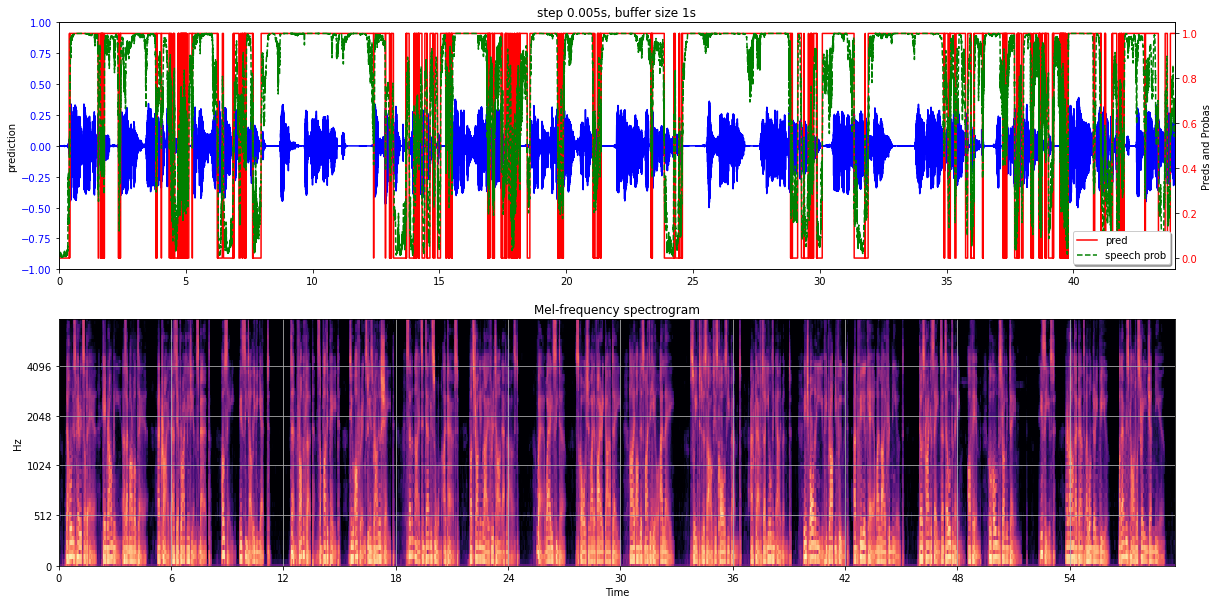

In [73]:
STEP_LIST =        [0.005]
WINDOW_SIZE_LIST = [1]


import wave

def offline_inference(wave_file, STEP = 0.025, WINDOW_SIZE = 0.5):
    
    FRAME_LEN = STEP # infer every STEP seconds 
    CHANNELS = 1 # number of audio channels (expect mono signal)
    RATE = 16000 # sample rate, Hz
    
   
    CHUNK_SIZE = int(FRAME_LEN*RATE)
    
    vad = FrameVAD(model_definition = {
                   'sample_rate': SAMPLE_RATE,
                   'AudioToMFCCPreprocessor': cfg.preprocessor,
                   'JasperEncoder': cfg.encoder,
                   'labels': cfg.labels
               },
               frame_len=FRAME_LEN, frame_overlap = (WINDOW_SIZE-FRAME_LEN)/2,
               offset=0)

    wf = wave.open(wave_file, 'rb')
    #p = pa.PyAudio()

    empty_counter = 0

    preds = []
    proba_b = []
    proba_s = []
    
    #stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
    #                channels=CHANNELS,
    #                rate=RATE,
    #                output = True)

    data = wf.readframes(CHUNK_SIZE)

    while len(data) > 0:

        data = wf.readframes(CHUNK_SIZE)
        signal = np.frombuffer(data, dtype=np.int16)
        result = vad.transcribe(signal)

        preds.append(result[0])
        proba_b.append(result[2])
        proba_s.append(result[3])
        
        if len(result):
            #print(result,end='\n')
            empty_counter = 3
        elif empty_counter > 0:
            empty_counter -= 1
            #if empty_counter == 0:
            #    print(' ',end='')
                
    #p.terminate()
    vad.reset()
    
    return preds, proba_b, proba_s
demo_wave = '/home/lucas/PycharmProjects/MetricEmbeddingNet/temp_files/without_vad/112383.wav'
wave_file = demo_wave

CHANNELS = 1
RATE = 16000
audio, sample_rate = librosa.load(wave_file, sr=RATE)
dur = librosa.get_duration(audio)
print(dur)

ipd.Audio(audio, rate=sample_rate)

results = []
for STEP, WINDOW_SIZE in zip(STEP_LIST, WINDOW_SIZE_LIST):
    print(f'====== STEP is {STEP}s, WINDOW_SIZE is {WINDOW_SIZE}s ====== ')
    preds, proba_b, proba_s = offline_inference(wave_file, STEP, WINDOW_SIZE)
    results.append([STEP, WINDOW_SIZE, preds, proba_b, proba_s])
    

import librosa.display
plt.figure(figsize=[20,10])

num = len(results)
for i in range(num):
    len_pred = len(results[i][2]) 
    FRAME_LEN = results[i][0]
    ax1 = plt.subplot(num+1,1,i+1)

    ax1.plot(np.arange(audio.size) / sample_rate, audio, 'b')
    ax1.set_xlim([-0.01, int(dur)+1]) 
    ax1.tick_params(axis='y', labelcolor= 'b')
    ax1.set_ylabel('Signal')
    ax1.set_ylim([-1,  1])

    ax2 = ax1.twinx()
    ax2.plot(np.arange(len_pred)/(1/results[i][0]), np.array(results[i][2])  , 'r', label='pred')
    ax2.plot(np.arange(len_pred)/(1/results[i][0]), np.array(results[i][4]) ,  'g--', label='speech prob')
    ax2.tick_params(axis='y', labelcolor='r')
    legend = ax2.legend(loc='lower right', shadow=True)
    ax1.set_ylabel('prediction')

    ax2.set_title(f'step {results[i][0]}s, buffer size {results[i][1]}s')
    ax2.set_ylabel('Preds and Probas')
    
    
ax = plt.subplot(num+1,1,i+2)
S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=64, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sample_rate, fmax=8000)
ax.set_title('Mel-frequency spectrogram')
ax.grid()
plt.show()